In [1]:
import warnings
warnings.filterwarnings('ignore')

<h1 style = "fontsize:400%;text-align:center;">QBUS3850: Time Series and Forecasting</h1>
<h2 style = "fontsize:300%;text-align:center;">GARCH</h2>
<h3 style = "fontsize:200%;text-align:center;">Lecture Notes</h3>

<h2 style = "fontsize:300%;text-align:center;">Extending ARCH</h2>

# ARCH Model

- Recall the ARCH(p) model is given by

$$\begin{aligned}u_t&=\sigma_t\epsilon_t\\\sigma^2_t&=\alpha_0+\alpha_1 u^2_{t-1}+\dots+\alpha_p u^2_{t-p}\end{aligned}$$

# Infinite lags

- A limitation is that the variance only depends on $p$ lags of $u^2$
- Is there a parsimonious way to make it depend on an infinite number of lags?
- Recall that in mean modelling, an ARMA could be written as either 
  - An infinite order AR model
  - An infinite order MA model
- How can we do this extend this idea to ARCH?

# Generalised ARCH (GARCH)

- The GARCH(1,1) is given by

$$\begin{aligned}u_t&=\sigma_t\epsilon_t\\\sigma^2_t&=\alpha_0+\alpha_1 u^2_{t-1}+\beta_1\sigma^2_{t-1}\end{aligned}$$

- Is $\alpha_1$ the "MA" term and $\beta_1$ the "AR" term?
- NO! Why not?
  - No $u_t^2$ on LHS and $u_t^2$ is not white noise.

# GARCH as an ARMA

- Add $u_t^2$ to both sides of previous equation

$$\begin{aligned}\sigma^2_t+u^2_t&=\alpha_0+\alpha_1 u^2_{t-1}+\beta_1\sigma^2_{t-1}+u_t^2\\\sigma^2_t+u^2_t&=\alpha_0+\alpha_1u^2_{t-1}\color{red}{-\beta_1u^2_{t-1}+\beta_1u^2_{t-1}}+\beta_1\sigma^2_{t-1}+u_t^2\\\sigma^2_t+u^2_t&=\alpha_0+(\alpha_1+\beta_1)u^2_{t-1}-\beta_1(u^2_{t-1}-\sigma_{t-1}^2)+u_t^2\\u^2_t&=\alpha_0+(\alpha_1+\beta_1)u^2_{t-1}+(u_t^2-\sigma^2_{t})-\beta_1(u^2_{t-1}-\sigma_{t-1}^2)\end{aligned}$$

- If we define $w_t=u_t^2-\sigma^2_{t}$ then

$$u^2_t=\alpha_0+(\alpha_1+\beta_1)u^2_{t-1}+w_t-\beta_1w_{t-1}$$

- It can be shown that $w_t$ is white noise.

# GARCH(p,q)

- The GARCH(p,q) is given by

$$\begin{aligned}u_t&=\sigma_t\epsilon_t\\\sigma^2_t&=\alpha_0+\alpha_1 u^2_{t-1}+\dots+\alpha_p u^2_{t-p}+\beta_1\sigma^2_{t-1}+\dots+\beta_q\sigma^2_{t-q}\end{aligned}$$

This can also be written as an ARMA(max(p,q),q). You can try this as an exercise.

# Parameter Constraints 

- To guarantee positive variances
  - Assume all parameters positive
  - Weaker conditions can be found as well
- To guarantee stationarity
  - Assume $\sum\limits_{j=1}^{\max(p,q)} (\alpha_i+\beta_i)<1$ where $\alpha_j=0$ for $j>p$ when $p<q$ and $\beta_j=0$ for $j>q$ when $p>q$
- The constraints are imposed in ML estimation.

# Parameter Estimation

- Conditional maximum likelihood is typically used.
  - Condition on actual values of $u_1$
  - Condition on $\sigma^2_0$ as unconditional variance
- Unlike ARMA, unconditional likelihood of a GARCH model is an open research question.

# In Python

Read in data and compute returns

In [1]:
import pandas as pd
import numpy as np
rio = pd.read_csv('BHP.AX.csv')
rio['Date'] = pd.to_datetime(rio['Date'])
ret=np.log(rio['Close']).diff()
from arch import arch_model

# Estimate

In [3]:

fitgarch11 = arch_model( ret[1:], mean='Constant', vol='GARCH', p=1, q=1 ).fit()
print( fitgarch11.summary() )

Iteration:      1,   Func. Count:      6,   Neg. LLF: 3.159062029668248e+19
Iteration:      2,   Func. Count:     18,   Neg. LLF: 1989154051.5722616
Iteration:      3,   Func. Count:     31,   Neg. LLF: 8.521591988793891e+19
Iteration:      4,   Func. Count:     44,   Neg. LLF: -3347.740599589584
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3347.7405932698794
            Iterations: 8
            Function evaluations: 44
            Gradient evaluations: 4
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                  Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:                3347.74
Distribution:                  Normal   AIC:                          -6687.48
Method:            Maximum Likelihood   BIC:                          -6666.90
                   

# Diagnostics: LM test

In [4]:
import statsmodels.api as sm
sres=fitgarch11.std_resid
sressq=pow(sres,2)
sm.stats.diagnostic.acorr_ljungbox(sressq,lags=10,model_df=2,return_df=True)

,lb_stat,lb_pvalue
1,0.054225,NaN
2,4.603307,NaN
3,4.762947,0.029079
4,4.925100,0.085217
5,6.355983,0.095519
6,13.834471,0.007843
7,14.772225,0.011381
8,14.893791,0.021099
9,14.960412,0.036510
10,16.271789,0.038651


# Diagnostics QQ plot

Jarque_beraResult(statistic=369.1470611254877, pvalue=0.0)

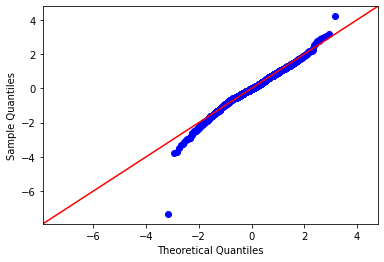

In [5]:
qq=sm.qqplot(sres,line='45')
qq.show()
import scipy 
scipy.stats.jarque_bera(sres)

<h2 style = "fontsize:300%;text-align:center;">Asymmetric GARCH</h2>

# Leverage effect

- The ARCH and GARCH models both assume that volatility only reacts to past volatility.
- The direction of returns can also influence volatility.
- It is common to empirically observe that negative returns lead to more volatlity in the following period compared to positive returns.
- This is often called the *leverage effect* and motivates many models, including GJR-GARCH and EGARCH


# Why leverage effect

- Original explanation was that falling prices increased the debt-to-equity ratio (leverage) and that companies with higher debt-to-equity were more volatile.
- This has since been discredited, as even exchange rates and commodity prices exhibit the feature of asymmetric volatility.
- However the original name has stuck!
- Sometimes you will hear this effect referred to as the volatility feedback effect.


# GJR- GARCH

- Proposed by **G**losten **J**agannathan and **R**unkle (1993) hence the name

$$\sigma^2_t = \alpha_0+\alpha_1 u^2_{t-1}+\gamma_1 I_{t-1}u^2_{t-1}+\beta_1\sigma^2_{t-1}$$

- Here $I_{t-1}=0$ if $u_{t-1}>0$ and $I_{t-1}=1$ if $u_{t-1}<0$

# GJR-GARCH

- Think of this as two GARCH models
- After positive returns
$$\sigma^2_t = \alpha_0+\alpha_1 u^2_{t-1}+\beta_1\sigma^2_{t-1}$$
- After negative returns
$$\sigma^2_t = \alpha_0+(\alpha_1+\gamma_1) u^2_{t-1}+\beta_1\sigma^2_{t-1}$$
- The parameter $\gamma_1$ measures the extent of the asymmetry

# In Python

- Use GARCH but set `o` option.

In [6]:

fitgjrgarch11 = arch_model( ret[1:], mean='Constant', vol='GARCH', p=1, q=1 , o=1).fit()
print( fitgjrgarch11.summary() )

Iteration:      1,   Func. Count:      7,   Neg. LLF: 1.4264721345428547e+18
Iteration:      2,   Func. Count:     20,   Neg. LLF: 108551.9860212103
Iteration:      3,   Func. Count:     31,   Neg. LLF: -3356.254698152263
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3356.2546967408616
            Iterations: 7
            Function evaluations: 31
            Gradient evaluations: 3
                   Constant Mean - GJR-GARCH Model Results                    
Dep. Variable:                  Close   R-squared:                      -0.000
Mean Model:             Constant Mean   Adj. R-squared:                 -0.000
Vol Model:                  GJR-GARCH   Log-Likelihood:                3356.25
Distribution:                  Normal   AIC:                          -6702.51
Method:            Maximum Likelihood   BIC:                          -6676.79
                                        No. Observations:                 1267
Date:           

# Diagnostics: LM test

In [7]:
import statsmodels.api as sm
sres=fitgjrgarch11.std_resid
sressq=pow(sres,2)
sm.stats.diagnostic.acorr_ljungbox(sressq,lags=10,model_df=2,return_df=True)

,lb_stat,lb_pvalue
1,0.195518,NaN
2,3.711607,NaN
3,3.716337,0.053882
4,4.717014,0.094561
5,6.213729,0.101662
6,10.906579,0.027634
7,11.203187,0.047497
8,11.530703,0.073295
9,11.867338,0.105007
10,12.703679,0.122460


# Diagnostics QQ plot

Jarque_beraResult(statistic=258.1049423571817, pvalue=0.0)

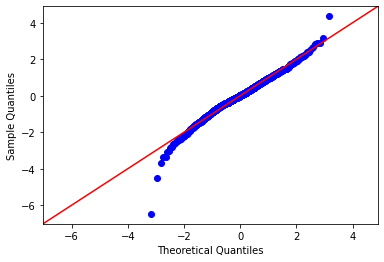

In [8]:
qq=sm.qqplot(sres,line='45')
qq.show()
import scipy 
scipy.stats.jarque_bera(sres)

# News impact curve

- Plots $\sigma_t$ as a function of $u^2_{t-1}$ setting $\sigma^2_{t-1},\sigma^2_{t-2},\dots$ to the unconditional variance 

In [9]:
# Get required estimated GJR model coefficients
a1GJ = fitgjrgarch11.params['alpha[1]']
b1GJ = fitgjrgarch11.params['beta[1]']
g1GJ = fitgjrgarch11.params['gamma[1]']
a0GJ = fitgjrgarch11.params['omega']
u = ret[1:,] - fitgjrgarch11.params['mu'] #Calculate innovations

#Calculate values for NIC plot
a = np.arange(min(u), max(u), 0.01) #Plot range
sg = np.var(u) #sample variance of innovations
nic_gjr = a0GJ + a1GJ * a**2 + b1GJ * sg + np.where(a < 0, g1GJ, 0)*(a**2) #asymmetric curve values



# News Impact Curve

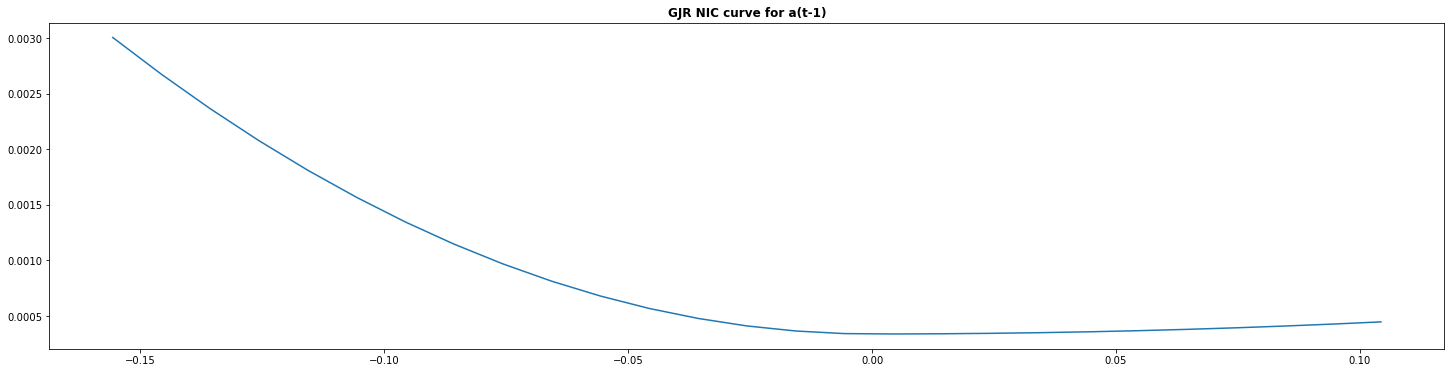

In [10]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(figsize = (25,6))
axs.plot(a, nic_gjr)
axs.set_title('GJR NIC curve for a(t-1)', weight = 'bold')
plt.show()

# E-Garch

- Shortcoming of GARCH is constraints on parameters to ensure positive variances.
- To get around this issue E-GARCH models log volatility

$$log(\sigma_t^2)=\alpha_0+\sum_{i=1}^p\alpha_i(|e_{t-i}|-\sqrt{2\pi})+\sum_{i=1}^o\gamma_ie_{t-i}+\sum^q_{j=1}\beta_jlog(\sigma^2_{t-j})$$

- You will find other notation in different sources, this closely matches that used in the [arch Python package](https://arch.readthedocs.io/en/latest/univariate/generated/arch.univariate.EGARCH.html).
- Note that $e_t=u_t/\sigma_t$ and $\sqrt{2\pi}$ is the expected value of $|\epsilon_t|$ if $\epsilon_t$ is normal.

# In Python

In [11]:
fitegarch11 = arch_model( ret[1:], mean='Constant', vol='EGARCH', p=1, q=1, o=1 ).fit()
print( fitegarch11.summary() )

Iteration:      1,   Func. Count:      7,   Neg. LLF: 8.889584945856823e+18
Iteration:      2,   Func. Count:     20,   Neg. LLF: 1079247366929.2538
Iteration:      3,   Func. Count:     30,   Neg. LLF: 511533471218.6262
Iteration:      4,   Func. Count:     41,   Neg. LLF: 136373535001.35631
Iteration:      5,   Func. Count:     51,   Neg. LLF: -3355.3792262444904
Iteration:      6,   Func. Count:     58,   Neg. LLF: 4672.029802712047
Iteration:      7,   Func. Count:     67,   Neg. LLF: -3363.595174746533
Iteration:      8,   Func. Count:     74,   Neg. LLF: -3363.975482507693
Iteration:      9,   Func. Count:     80,   Neg. LLF: -3363.976214143844
Iteration:     10,   Func. Count:     86,   Neg. LLF: -3363.9762223109774
Iteration:     11,   Func. Count:     92,   Neg. LLF: -3363.976223087476
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3363.976223087476
            Iterations: 11
            Function evaluations: 92
            Gradient 

# NIC curve

In [12]:
sig = fitegarch11.conditional_volatility #infer the conditional standard deviations
e= u / sig

alpha = fitegarch11.params['alpha[1]'] #parameter in front of |e(t-1)|
gamma = fitegarch11.params['gamma[1]'] #asymmetric parameter, in front of e(t-1)
beta = fitgarch11.params['beta[1]']
omega = fitgarch11.params['omega']

egrid = np.arange(e.min(), e.max(), 0.01)
nic_e = np.exp(omega+alpha*(abs(egrid)-np.sqrt(2/np.pi))+gamma*egrid+beta*np.log(sg))



# Plot

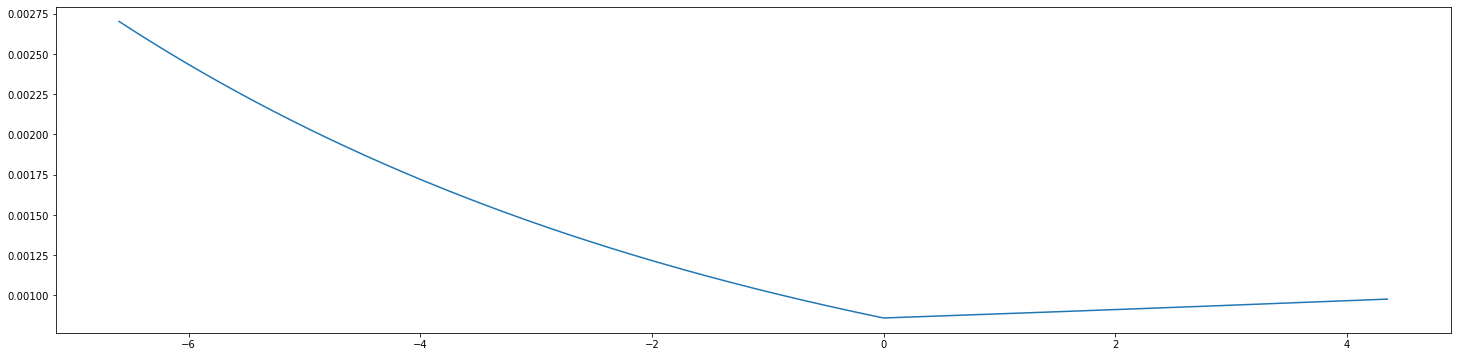

In [13]:
fig, axs = plt.subplots(figsize = (25,6))
axs.plot(egrid, nic_e)
plt.show()

# EWMA

- Not all extensions to GARCH models make things more complicated.
- A popular approach is the exponentially weighted moving average (EWMA)

$$\sigma_t^2=\lambda\sigma^2_{t-1}+(1-\lambda)u^2_{t-1}$$

- This is a GARCH(1,1) with the constraint that $\alpha_0=0$ $\alpha_1+\beta_1=1$.
- Developed by J.P.Morgan in the 1989 who set $\lambda=0.94$ (other values can be used).
- Estimation difficult since model is non-stationary.

# Fitting EWMA

In [14]:
from arch.univariate import EWMAVariance, ConstantMean
ewma = ConstantMean(ret[1:])
ewma.volatility = EWMAVariance(0.94)
fitewma = ewma.fit()
print( fitewma.summary() )

Iteration:      1,   Func. Count:      3,   Neg. LLF: 20712930783.50821
Iteration:      2,   Func. Count:     12,   Neg. LLF: -3341.560746545524
Iteration:      3,   Func. Count:     13,   Neg. LLF: -3341.560746551215
Optimization terminated successfully    (Exit mode 0)
            Current function value: -3341.560746545524
            Iterations: 3
            Function evaluations: 13
            Gradient evaluations: 3
                Constant Mean - EWMA/RiskMetrics Model Results                
Dep. Variable:                  Close   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:           EWMA/RiskMetrics   Log-Likelihood:                3341.56
Distribution:                  Normal   AIC:                          -6681.12
Method:            Maximum Likelihood   BIC:                          -6675.98
                                        No. Observations:                 1267
Date:                

# Wrap up

- Many extensions to ARCH
  + Allow dependence 
  + Leverage effect
  + Deal with variances being positive
- At the other end of the spectrum - EWMA
- Can compare by AIC or forecasting performance